## Detector model: Kiukas / Ruschhaupt / Schmidt / Werner

In [432]:
from sympy import *
#from sympy.physics.matrices import mdft
from sympy.physics.quantum import TensorProduct
from sympy.functions.special.delta_functions import Heaviside
from sympy.physics.quantum.dagger import Dagger

from sympy.stats import ContinuousRV, variance, std

from sympy.plotting import plot, plot3d_parametric_line

import numpy as np

import scipy.integrate

import matplotlib
import matplotlib.pyplot as plt

# matplotlib.rcParams['text.usetex'] = False

# https://matplotlib.org/gallery/mplot3d/lines3d.html?highlight=parametric
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

In [433]:
from IPython.display import display, Latex #, Math

In [434]:
init_printing ()

In [435]:
gamma = Symbol('gamma', real=True, positive=True)
t = Symbol('t', real=True)
tprime = Symbol('t\'', real=True)
omega = Symbol('omega', real=True)
nu = Symbol('nu', real=True)

In [436]:
H = Matrix ([
    [0, 1, 0],
    [1, 0, 1],
    [0, 1, 0]
])

In [437]:
H.eigenvects()

⎡⎛      ⎡⎡-1⎤⎤⎞  ⎛        ⎡⎡ 1 ⎤⎤⎞  ⎛       ⎡⎡1 ⎤⎤⎞⎤
⎢⎜      ⎢⎢  ⎥⎥⎟  ⎜        ⎢⎢   ⎥⎥⎟  ⎜       ⎢⎢  ⎥⎥⎟⎥
⎢⎜0, 1, ⎢⎢0 ⎥⎥⎟, ⎜-√2, 1, ⎢⎢-√2⎥⎥⎟, ⎜√2, 1, ⎢⎢√2⎥⎥⎟⎥
⎢⎜      ⎢⎢  ⎥⎥⎟  ⎜        ⎢⎢   ⎥⎥⎟  ⎜       ⎢⎢  ⎥⎥⎟⎥
⎣⎝      ⎣⎣1 ⎦⎦⎠  ⎝        ⎣⎣ 1 ⎦⎦⎠  ⎝       ⎣⎣1 ⎦⎦⎠⎦

In [438]:
U_t = exp(-I*H*t)

In [439]:
psi_0 = Matrix([1, (1+I)/sqrt(2), 0])/sqrt(2)
psi_0

⎡ √2  ⎤
⎢ ──  ⎥
⎢ 2   ⎥
⎢     ⎥
⎢1   ⅈ⎥
⎢─ + ─⎥
⎢2   2⎥
⎢     ⎥
⎣  0  ⎦

In [440]:
unitary_psi_t = U_t @ psi_0

In [441]:
unitary_psi_t

⎡                                          ⎛ √2⋅ⅈ⋅t        -√2⋅ⅈ⋅t⎞⎤
⎢                                          ⎜ℯ         1   ℯ       ⎟⎥
⎢        ⎛      √2⋅ⅈ⋅t       -√2⋅ⅈ⋅t⎞   √2⋅⎜─────── + ─ + ────────⎟⎥
⎢⎛1   ⅈ⎞ ⎜  √2⋅ℯ         √2⋅ℯ       ⎟      ⎝   4      2      4    ⎠⎥
⎢⎜─ + ─⎟⋅⎜- ────────── + ───────────⎟ + ───────────────────────────⎥
⎢⎝2   2⎠ ⎝      4             4     ⎠                2             ⎥
⎢                                                                  ⎥
⎢     ⎛      √2⋅ⅈ⋅t       -√2⋅ⅈ⋅t⎞                                 ⎥
⎢     ⎜  √2⋅ℯ         √2⋅ℯ       ⎟                                 ⎥
⎢  √2⋅⎜- ────────── + ───────────⎟           ⎛ √2⋅ⅈ⋅t    -√2⋅ⅈ⋅t⎞  ⎥
⎢     ⎝      4             4     ⎠   ⎛1   ⅈ⎞ ⎜ℯ         ℯ       ⎟  ⎥
⎢  ─────────────────────────────── + ⎜─ + ─⎟⋅⎜─────── + ────────⎟  ⎥
⎢                 2                  ⎝2   2⎠ ⎝   2         2    ⎠  ⎥
⎢                                                                  ⎥
⎢                                 

In [442]:
prob_t = Matrix([0, 0, 0])
for i in 0, 1, 2:
    prob_t[i] = abs(unitary_psi_t[i])**2

In [443]:
prob_t

⎡   2⋅√2⋅ⅈ⋅t      2⋅√2⋅ⅈ⋅t    √2⋅ⅈ⋅t      √2⋅ⅈ⋅t         -√2⋅ⅈ⋅t      -√2⋅ⅈ⋅t 
⎢  ℯ           ⅈ⋅ℯ           ℯ         ⅈ⋅ℯ         5    ℯ          ⅈ⋅ℯ        
⎢- ───────── - ─────────── + ─────── - ───────── + ── + ──────── + ────────── 
⎢      32           16          8          8       16      8           8      
⎢                                                                             
⎢                         2⋅√2⋅ⅈ⋅t      2⋅√2⋅ⅈ⋅t        -2⋅√2⋅ⅈ⋅t      -2⋅√2⋅ⅈ
⎢                        ℯ           ⅈ⋅ℯ           3   ℯ            ⅈ⋅ℯ       
⎢                        ───────── + ─────────── + ─ + ────────── - ──────────
⎢                            16           8        8       16            8    
⎢                                                                             
⎢   2⋅√2⋅ⅈ⋅t      2⋅√2⋅ⅈ⋅t    √2⋅ⅈ⋅t      √2⋅ⅈ⋅t         -√2⋅ⅈ⋅t      -√2⋅ⅈ⋅t 
⎢  ℯ           ⅈ⋅ℯ           ℯ         ⅈ⋅ℯ         5    ℯ          ⅈ⋅ℯ        
⎢- ───────── - ─────────── - ─────── + ───────── + ─

In [444]:
simplify(
    prob_t[0] + prob_t[1] + prob_t[2]
)

In [445]:
unitary_psi_n = lambdify(t, unitary_psi_t, 'numpy')
prob_n = lambdify(t, prob_t, 'numpy')

In [500]:
def phase_color(_z):
    return np.imag(_z) # np.sin(np.angle(_z))

#### Complex argument color code
* <span style="color: #fe0">__Yellow__</span> (or generally the "highest"): imaginary, positive
* <span style="color: #086">__Green__ </span> (or generally the "midrange"): real
* <span style="color: #408">__Purple__</span> (or generally the "lowest"): imaginary, negative

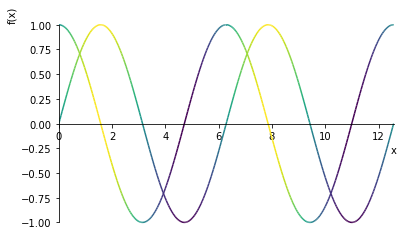

In [506]:
# Demo
pl = plot(
    ( re(exp(I*t)), (t, 0, 4*pi) ),
    ( im(exp(I*t)), (t, 0, 4*pi) ),
    show=False,
    adaptive=False
)
# Need the numeric version to customize color function
pl[0].line_color = lambda _t: phase_color( 1+ np.exp(1j*_t) )
pl[1].line_color = pl[0].line_color
pl.show()

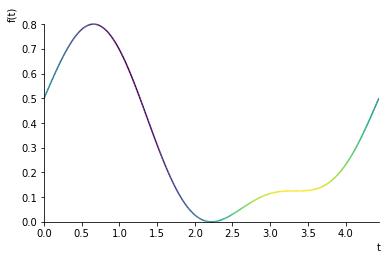

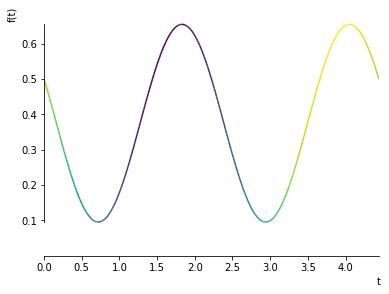

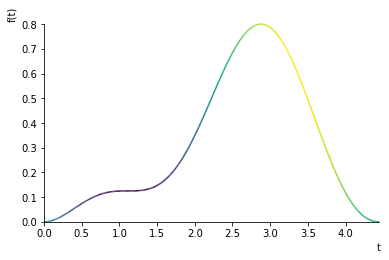

In [502]:
for i in 0, 1, 2:
    pl = plot(prob_t[i], (t, 0, 2*pi/sqrt(2)), adaptive=False, show=False)
    # Need the numeric version to customize color function
    pl[0].line_color = lambda _t: phase_color( unitary_psi_n(_t)[i] )
    pl.axis_center = (0, 0)
    pl.show()